# Simulation and Performance Evaluation - Homework 4

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

In [1]:
from enum import Enum

class EventTypes(Enum):
    start_simulation = 0,
    end_simulation = 1,
    packet_arrival = 2,
    packet_departure = 3,
    debug = 4

In [3]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.next_event = None

In [242]:
class Queue:
    def __init__(self):
        self.first_event = None


    def insert_event(self, event:Event):
        if event.occurrence_time < self.first_event.occurrence_time:
            event.next_event = self.first_event
            self.first_event = event
        else:
            curr_event = self.first_event
            while curr_event.next_event is not None and \
                    event.occurrence_time > curr_event.next_event.occurrence_time:
                curr_event = curr_event.next_event

            event.next_event = curr_event.next_event
            curr_event.next_event = event


    def print(self):
        curr_event = self.first_event
        while curr_event is not None:
            print("->", curr_event.occurrence_time, curr_event.event_type)
            curr_event = curr_event.next_event


    def pop(self):
        if self.first_event is None:
            return None

        curr_event = self.first_event
        self.first_event = self.first_event.next_event

        return curr_event


In [243]:
queue = Queue()
curr_time = 0
max_time = 1000

start_event = Event(curr_time, EventTypes.start_simulation)
end_event = Event(max_time, EventTypes.end_simulation)

queue.first_event = start_event
queue.insert_event(end_event)

queue.print()

-> 0 EventTypes.start_simulation
-> 1000 EventTypes.end_simulation


In [244]:
events = [
    Event(100, EventTypes.packet_departure),
    Event(-50, EventTypes.packet_arrival),
    Event(842, EventTypes.packet_departure),
    Event(684, EventTypes.packet_arrival),
    Event(354, EventTypes.packet_arrival),
    Event(956, EventTypes.packet_departure),
    Event(715, EventTypes.debug),
    Event(20, EventTypes.packet_arrival),
    Event(953, EventTypes.packet_departure)
]

for e in events:
    queue.insert_event(e)

queue.print()

-> -50 EventTypes.packet_arrival
-> 0 EventTypes.start_simulation
-> 20 EventTypes.packet_arrival
-> 100 EventTypes.packet_departure
-> 354 EventTypes.packet_arrival
-> 684 EventTypes.packet_arrival
-> 715 EventTypes.debug
-> 842 EventTypes.packet_departure
-> 953 EventTypes.packet_departure
-> 956 EventTypes.packet_departure
-> 1000 EventTypes.end_simulation


In [245]:
class Server:
    def __init__(self):
        self.server_status = 0  # 0 means available, 1 means busy
        self.queue = []

In [246]:
while True:
    event = queue.pop()
    if event is None:
        continue
    if event.event_type == EventTypes.start_simulation:
        print("start simulation")
    elif event.event_type == EventTypes.packet_arrival:
        print("packet arrival")
    elif event.event_type == EventTypes.packet_departure:
        print("packet departure")
    elif event.event_type == EventTypes.debug:
        print("debug")
    elif event.event_type == EventTypes.end_simulation:
        print("end simulation")
        break


packet arrival
start simulation
packet arrival
packet departure
packet arrival
packet arrival
debug
packet departure
packet departure
packet departure
end simulation


In [298]:
import random as rnd

def exponential_val(lambda_val):
    return rnd.expovariate(lambda_val)


def simulate(arr_val, max_time):
    curr_time = 0
    queue = Queue()

    arrival_time = exponential_val(arr_val)
    curr_time += arrival_time

    queue.first_event = Event(curr_time, EventTypes.start_simulation)

    while curr_time < max_time:
        arrival_time = exponential_val(arr_val)
        curr_time += arrival_time

        if curr_time >= max_time:
            e = Event(curr_time, EventTypes.end_simulation)
        else:
            e = Event(curr_time, EventTypes.packet_arrival)

        queue.insert_event(e)

    return queue

In [281]:
def manage_packets(q, server, server_lambda):
    packet_time = []
    packet_status = []
    delay_in_queue = []
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            if server.server_status == 0:  # server free
                server.server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)
            else:  # server busy
                server.queue.append(event)
        elif event.event_type == EventTypes.packet_departure:
            if len(server.queue) == 0:
                server.server_status = 0
            else:  # schedule next departure event
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)

                delay_in_queue.append(e.occurrence_time - server.queue[0].occurrence_time)
                server.queue = server.queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

        if len(packet_time) and event.occurrence_time < packet_time[-1]:
            print(event.occurrence_time, event.event_type)
            print(packet_time[-1])

        packet_time.append(event.occurrence_time)
        num_packets = len(server.queue) + server.server_status
        packet_status.append(num_packets)

    return packet_time, packet_status, delay_in_queue

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_simulation(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, _ = manage_packets(q, s, mu)

    plt.plot(packet_time, packet_status)

    p = lmbda / mu
    theory_val = p/(1-p)
    theoretical = [theory_val] * len(packet_time)

    plt.plot(packet_time, theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Number of packets in the system')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Number of packets in the system - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()


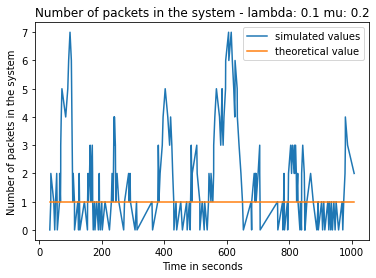

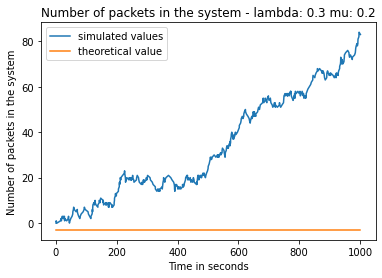

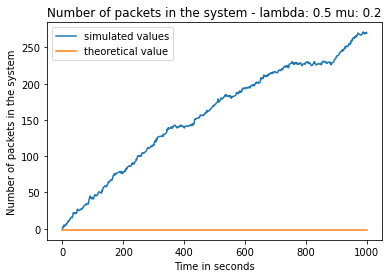

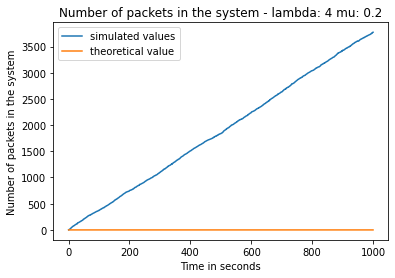

In [268]:
plot_simulation(0.1, 0.2, 1000)
plot_simulation(0.3, 0.2, 1000)
plot_simulation(0.5, 0.2, 1000)
plot_simulation(4, 0.2, 1000)

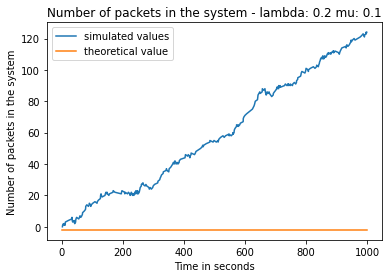

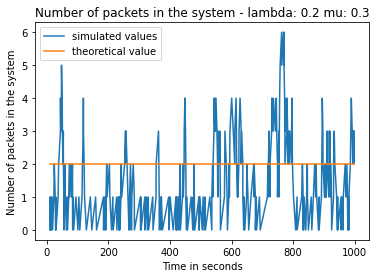

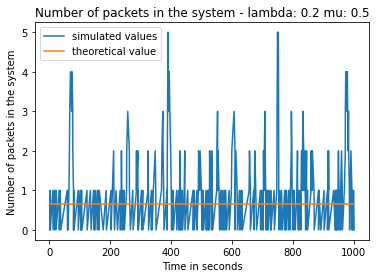

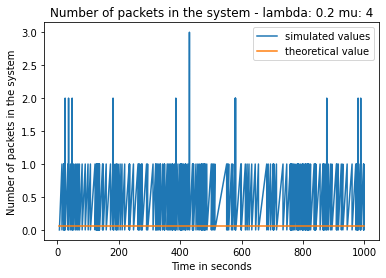

In [269]:
plot_simulation(0.2, 0.1, 1000)
plot_simulation(0.2, 0.3, 1000)
plot_simulation(0.2, 0.5, 1000)
plot_simulation(0.2, 4, 1000)

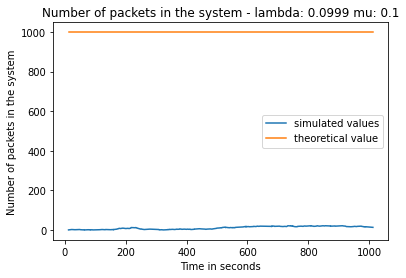

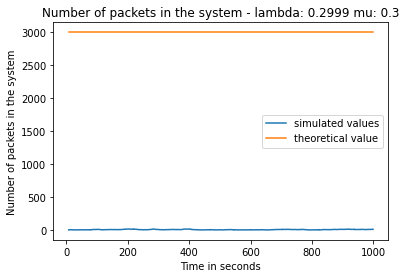

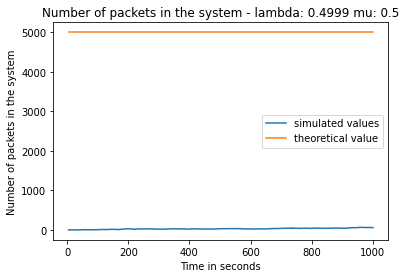

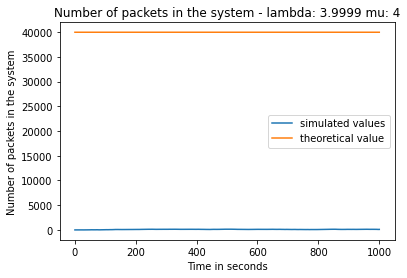

In [270]:
plot_simulation(0.0999, 0.1, 1000)
plot_simulation(0.2999, 0.3, 1000)
plot_simulation(0.4999, 0.5, 1000)
plot_simulation(3.9999, 4, 1000)

In [300]:
def calc_simulation_wait(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, packet_wait = manage_packets(q, s, mu)

    p = lmbda / mu
    theory_val = p**2 / (lmbda * (1-p))

    mean_wait = sum(packet_wait) / len(packet_wait)

    print("Lambda: {}, Mu: {}".format(lmbda, mu))
    print("Simulated mean time in queue: {:0.3f}".format(mean_wait))
    print("Theoretical mean time in queue: {:0.3f}".format(theory_val))


In [317]:
calc_simulation_wait(0.5, 0.6, 1000)

Lambda: 0.5, Mu: 0.6
Simulated mean time in queue: 9.035
Theoretical mean time in queue: 8.333
